### Setup

In [41]:
from openai import OpenAI
from tqdm import tqdm
import os
import math
from tvalmetrics import RagScoresCalculator
from concurrent.futures import ThreadPoolExecutor

client = OpenAI()

In [42]:
RUN_COMBINE_ESSAYS = True

def get_sorted_essays():
    # Sort the files so that they are uploaded in order
    combined_essays = os.listdir('combined_essays')
    combined_essays.sort(key=lambda x: int(x.split('_')[2].split('.')[0]))
    print("\n".join(combined_essays))
    return combined_essays

# Iterate through paul_graham_essays folder and upload each file to the assistant
# Apparently you can't upload more than 20 items to openai's rag so let's just combine them and upload those
def combine_essays(group_num):
    if not RUN_COMBINE_ESSAYS:
        return
    essays = os.listdir('paul_graham_essays')
    group_size = math.ceil(len(essays) / group_num)
    print(f"Grouping {len(essays)} files into groups of {group_size} files for a total of {group_num} groups")


    # Create directory for combined essays
    if not os.path.exists('combined_essays'):
        os.makedirs('combined_essays')
    else:
        # delete all files in combined_essays
        for filename in os.listdir('combined_essays'):
            os.remove(f'combined_essays/{filename}')

    group_counter = 0
    file_counter = 1
    curr_file_text = ""
    for filename in tqdm(essays):
        with open('paul_graham_essays/' + filename, 'r') as file:
            curr_file_text += file.read().strip() + "\n\n\n\n"
            group_counter += 1
            if group_counter == group_size:
                # Write to file
                with open(f'combined_essays/paul_graham_{file_counter}.txt', 'w') as combined_file:
                    combined_file.write(curr_file_text)
                    file_counter += 1
                curr_file_text = ""
                group_counter = 0
    
    if curr_file_text.strip():
        with open(f'combined_essays/paul_graham_{file_counter}.txt', 'w') as combined_file:
            combined_file.write(curr_file_text)
    return get_sorted_essays()

In [43]:
import time


def get_response(prompt, assistant):
    thread = client.beta.threads.create(
        messages=[
            {
                "role": "user",
                "content": prompt
            }
        ]
    )
    run = client.beta.threads.runs.create(
        thread_id=thread.id,
        assistant_id=assistant.id,
    )
    max_tries = 180
    try:
        while True:
            if max_tries == 0:
                client.beta.threads.delete(thread.id)
                raise Exception("Max tries exceeded")
            messages = client.beta.threads.messages.list(
                thread_id=thread.id,
            )
            response_message = messages.data[0].content[0].text.value
            if response_message != prompt and response_message.strip():
                client.beta.threads.delete(thread.id)
                return response_message
            time.sleep(1)
            max_tries -= 1
    except Exception as e:
        client.beta.threads.delete(thread.id)
        raise e

In [44]:
# Load questions from qa_pairs.json
import json
qa_pairs = []
with open('qa_pairs.json', 'r') as qa_file:
    qa_pairs = json.load(qa_file)

question_list = [qa_pair['question'] for qa_pair in qa_pairs]
print("Questions:\n" + "\n".join(question_list[:4]))

print()

answer_list = [qa_pair['answer'] for qa_pair in qa_pairs]
print("Answers:\n" + "\n".join(question_list[:4]))

Questions:
What key components are necessary to create a technology hub according to Paul Graham?
What is the influence of geography on where great cities historically developed, and how has that changed in modern times?
How are people classified according to their degree and aggressiveness of conformism?
What is the main danger of restricting the discussion of certain ideas?

Answers:
What key components are necessary to create a technology hub according to Paul Graham?
What is the influence of geography on where great cities historically developed, and how has that changed in modern times?
How are people classified according to their degree and aggressiveness of conformism?
What is the main danger of restricting the discussion of certain ideas?


In [45]:
score_calculator = RagScoresCalculator(
    model="gpt-4-1106-preview",
    answer_similarity_score=True,
)

#### Cleanup

In [46]:
# Do not run the following unless you want to delete all files and assistants

# def cleanup_files():
#     curr_files = list(client.files.list())
#     for file in tqdm(curr_files):
#         client.files.delete(file.id)

# def cleanup_assistants():
#     curr_assistants = list(client.beta.assistants.list())
#     for curr_assistant in tqdm(curr_assistants):
#         client.beta.assistants.delete(curr_assistant.id)

# def cleanup_all():
#     print("Cleaning up files")
#     cleanup_files()
#     print("Cleaning up assistants")
#     cleanup_assistants()

# cleanup_all()


### LlamaIndex

#### Setup

In [47]:
from typing import Any
from llama_index.llms import (
    CustomLLM,
    CompletionResponse,
    CompletionResponseGen,
    LLMMetadata,
)
from llama_index.llms.base import llm_completion_callback
from openai.types.beta.assistant import Assistant

class AssistantLLM(CustomLLM):
    llama_assistant: Assistant
    
    @property
    def metadata(self) -> LLMMetadata:
        """Get LLM metadata."""
        return LLMMetadata(
            context_window=128000,
            num_output=4096,
            model_name="gpt-4-1106-preview",
        )

    @llm_completion_callback()
    def complete(self, prompt: str, **kwargs: Any) -> CompletionResponse:
        response = get_response(prompt, self.llama_assistant)
        return CompletionResponse(text=response)

    @llm_completion_callback()
    def stream_complete(
        self, prompt: str, **kwargs: Any
    ) -> CompletionResponseGen:
        raise NotImplementedError()


In [49]:
from llama_index import ServiceContext, VectorStoreIndex, SimpleDirectoryReader

def setup_assistant(file_count):
    combined_essays = combine_essays(file_count)
    # Llama Index already injects into the prompt that the chatbot should not use external knowledge so we don't need to specify it here.
    llama_assistant = client.beta.assistants.create(
        name=f"LLamaIndex Rag Test {file_count} Files",
        instructions=(
            "You are a chatbot that answers questions about Paul Graham's essays. "
        ),
        model="gpt-4-1106-preview",
    )
    service_context = ServiceContext.from_defaults(llm=AssistantLLM(llama_assistant=llama_assistant))
    documents = SimpleDirectoryReader("combined_essays").load_data()
    index = VectorStoreIndex.from_documents(documents, service_context=service_context, show_progress=True)
    query_engine = index.as_query_engine(service_context=service_context)
    return query_engine


#### Testing

In [9]:
assistant = setup_assistant(1)

Grouping 212 files into groups of 212 files for a total of 1 groups


100%|██████████| 212/212 [00:00<00:00, 1617.76it/s]

paul_graham_1.txt



C:\Users\EthanPhilpott\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating embeddings: 100%|██████████| 665/665 [00:34<00:00, 19.22it/s]


In [10]:
def get_llama_response(prompt):
    response = assistant.query(prompt)
    context = [x.text for x in response.source_nodes]
    return (response.response, context)

In [11]:
llama_response = get_llama_response("What was Airbnb's monthly financial goal to achieve ramen profitability during their time at Y Combinator?")
print(llama_response[0])
print(llama_response[1])

Airbnb's monthly financial goal to achieve ramen profitability during their time at Y Combinator was $4,000 a month.
['That was the problem during Y Combinator: to get growth started. Airbnb\'s goal during YC was to reach what we call ramen profitability, which means making enough money that the company can pay the founders\' living expenses, if they live on ramen noodles. Ramen profitability is not, obviously, the end goal of any startup, but it\'s the most important threshold on the way, because this is the point where you\'re airborne. This is the point where you no longer need investors\' permission to continue existing. For the Airbnbs, ramen profitability was $4000 a month: $3500 for rent, and $500 for food. To celebrate Airbnb\'s IPO and to help future founders, I thought it might be useful to explain what was special about Airbnb. What was special about the Airbnbs was how earnest they were. They did nothing half-way, and we could sense this even in the interview. Sometimes aft

In [12]:
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

# Using ThreadPoolExecutor to process questions in parallel
with ThreadPoolExecutor(max_workers=10) as executor:
    # Map the process_question function to each question in the list
    results = list(tqdm(executor.map(get_llama_response, question_list), total=len(question_list)))

# Unpack results into separate lists
llama_responses, llama_context = zip(*results)

  0%|          | 0/55 [00:00<?, ?it/s]

100%|██████████| 55/55 [01:25<00:00,  1.55s/it]


In [13]:
openai_batch_scores = score_calculator.score_batch(
    question_list=question_list,
    reference_answer_list=answer_list,
    llm_answer_list=llama_responses,
)

In [14]:
openai_scores_df = openai_batch_scores.to_dataframe()
# Remove overall_score column since we are only using one stat
openai_scores_df = openai_scores_df.drop(columns=['overall_score'])
openai_scores_df.describe()

,answer_similarity_score
count,55.000000
mean,3.727273
std,1.592279
min,0.000000
25%,2.000000
50%,4.000000
75%,5.000000
max,5.000000


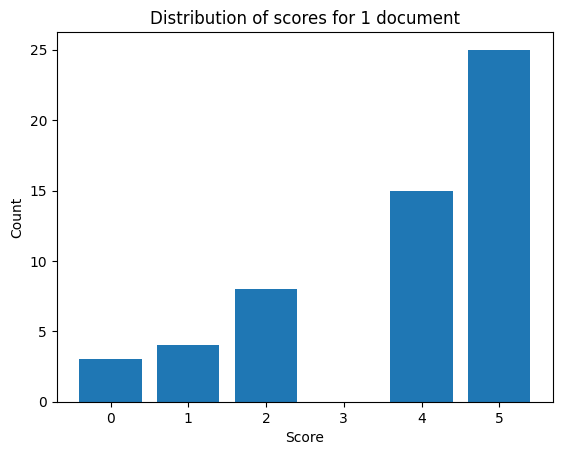

In [15]:
import matplotlib.pyplot as plt
category_counts = openai_scores_df['answer_similarity_score'].value_counts()
plt.bar(category_counts.index, category_counts.values)

plt.title('Distribution of scores for 1 document')
plt.xlabel('Score')
plt.ylabel('Count')

plt.show()

### Test

In [50]:
from llama_index import ServiceContext, StorageContext, VectorStoreIndex, SimpleDirectoryReader
from llama_index.vector_stores import PGVectorStore

def setup_assistant(file_count):
    combined_essays = combine_essays(file_count)
    # Llama Index already injects into the prompt that the chatbot should not use external knowledge so we don't need to specify it here.
    llama_assistant = client.beta.assistants.create(
        name=f"LLamaIndex Rag Test {file_count} Files",
        instructions=(
            "You are a chatbot that answers questions about Paul Graham's essays. "
        ),
        model="gpt-4-1106-preview",
    )
    service_context = ServiceContext.from_defaults(llm=AssistantLLM(llama_assistant=llama_assistant), chunk_size=80, chunk_overlap=60)
    documents = SimpleDirectoryReader("combined_essays").load_data()
    
    # Go through all the documents and add file_path to the excluded metadata
    for document in tqdm(documents):
        document.excluded_embed_metadata_keys.append("file_path")
        document.excluded_llm_metadata_keys.append("file_path")

    vector_store = PGVectorStore.from_params(
        database="postgres",
        host="localhost",
        password="admin",
        port="5433",
        user="postgres",
        table_name="paul_graham_essay",
        embed_dim=1536,  # openai embedding dimension
        hybrid_search=True,
        text_search_config="english"
    )
    storage_context = StorageContext.from_defaults(vector_store=vector_store)
    index = VectorStoreIndex.from_documents(documents, service_context=service_context, storage_context=storage_context, show_progress=True)
    query_engine = index.as_query_engine(vector_store_query_mode="hybrid", service_context=service_context, sparse_top_k=8)
    return query_engine


In [51]:
assistant = setup_assistant(1)

Grouping 212 files into groups of 212 files for a total of 1 groups




100%|██████████| 212/212 [00:00<00:00, 1558.31it/s]

paul_graham_1.txt




100%|██████████| 1/1 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 9/22962 [01:00<42:37:48,  6.69s/it]

Generating embeddings: 100%|██████████| 22962/22962 [24:25<00:00, 15.67it/s]  


In [52]:
def get_llama_response(prompt):
    response = assistant.query(prompt)
    context = [x.text for x in response.source_nodes]
    return (response.response, context)

In [53]:
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

# Using ThreadPoolExecutor to process questions in parallel
with ThreadPoolExecutor(max_workers=10) as executor:
    # Map the process_question function to each question in the list
    results = list(tqdm(executor.map(get_llama_response, question_list), total=len(question_list)))

# Unpack results into separate lists
llama_responses, llama_context = zip(*results)

  0%|          | 0/55 [00:00<?, ?it/s]

c:\Users\EthanPhilpott\AppData\Local\Programs\Python\Python311\Lib\site-packages\llama_index\vector_stores\postgres.py:449: SAWarning: UserDefinedType REGCONFIG() will not produce a cache key because the ``cache_ok`` attribute is not set to True.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  Set this attribute to True if this type object's state is safe to use in a cache key, or False to disable this warning. (Background on this warning at: https://sqlalche.me/e/20/cprf)
  res = session.execute(stmt)
100%|██████████| 55/55 [01:19<00:00,  1.44s/it]


In [57]:
openai_batch_scores = score_calculator.score_batch(
    question_list=question_list,
    reference_answer_list=answer_list,
    llm_answer_list=llama_responses,
)

In [58]:
openai_scores_df = openai_batch_scores.to_dataframe()
# Remove overall_score column since we are only using one stat
openai_scores_df = openai_scores_df.drop(columns=['overall_score'])
openai_scores_df.describe()

,answer_similarity_score
count,55.000000
mean,4.000000
std,1.440165
min,0.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


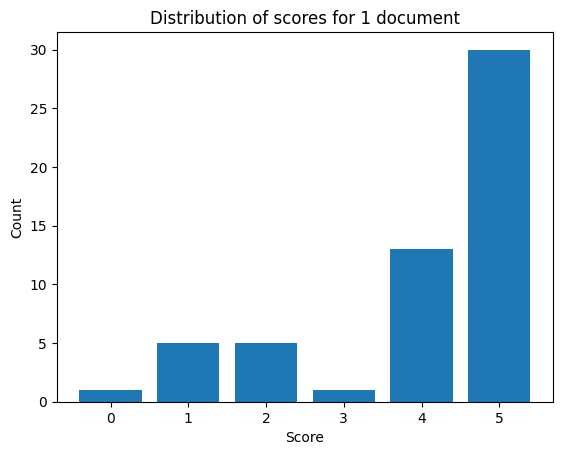

In [59]:
import matplotlib.pyplot as plt
category_counts = openai_scores_df['answer_similarity_score'].value_counts()
plt.bar(category_counts.index, category_counts.values)

plt.title('Distribution of scores for 1 document')
plt.xlabel('Score')
plt.ylabel('Count')

plt.show()